# Task 2: Create a Predictive Algorithm

In your second task, you were expected to create model that classifies your labels that done in the first task.
Create a model by using Python or R. You are free to choose your algorithm and libraries / packages to use.

Finally, tune your hyper-parameters of your model by randomized search, grid search or any other search method and explain your reasoning for this choice.

---

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [61]:
df = pd.read_csv('./data/Courier_data.csv')

In [62]:
df.head()

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_14,feature_15,feature_16,feature_17,lifetime_2,lifetime_1_a,lifetime_1_b,lifetime_1_c,lifetime_1_d,flag
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,...,0.8158,43.384804,1,19,33.0,0,1,0,0,1
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,...,0.8919,35.078042,3,11,33.0,0,1,0,0,1
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,...,0.9302,31.455285,1,10,33.0,0,1,0,0,1
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,...,0.7879,34.252991,1,30,33.0,0,1,0,0,1
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,...,0.8889,46.478114,1,4,35.0,1,0,0,0,0


---
## Data Exploration

In [119]:
# Write a proxy method to be passed to `pipe`
def agg_assign(gb, fdict):
    data = {
        (cl, nm): gb[cl].agg(fn)
        for cl, d in fdict.items()
        for nm, fn in d.items()
    }
    pd.options.display.float_format = '{:.0f}'.format
    return pd.DataFrame(data)

Distribution of flags (relatively balanced)

In [63]:
pd.DataFrame(
    {
        'Count': df.groupby('flag')['flag'].count(),
        'Percentage': df.groupby(('flag')).size() / len(df), 
    }
)

,Count,Percentage
flag,,
0,1969,0.650909
1,1056,0.349091


Determine most important features and check correlations

<h6 class="text-muted">Correlation matrix</h6>

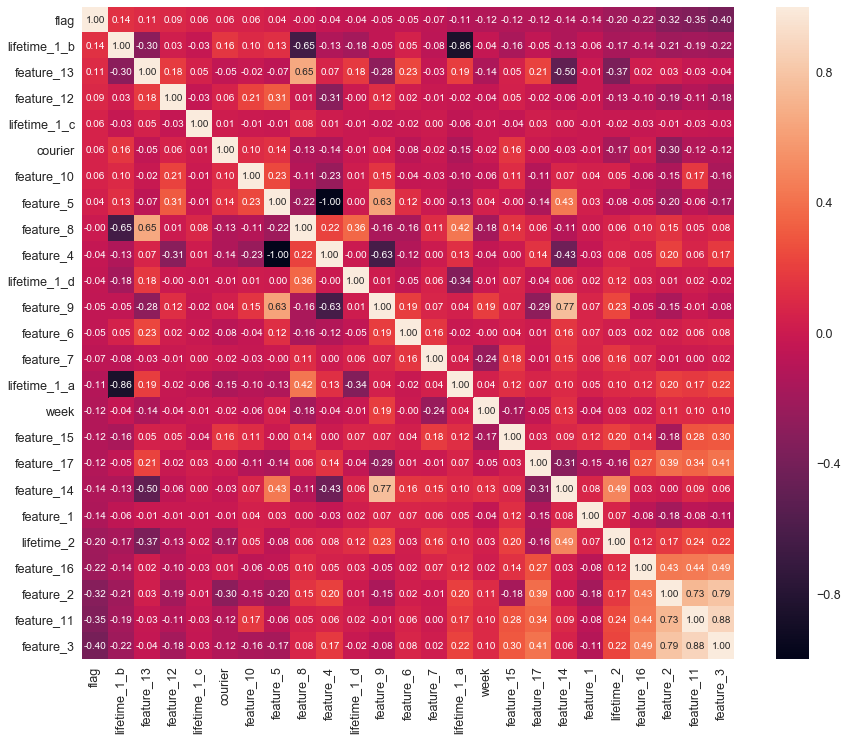

In [64]:
# flag correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 12))
k = 25 #number of variables for heatmap
cols = corrmat.nlargest(k, 'flag')['flag'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<h6 class="text-muted">Random Forest (feature importance)</h6>

In [68]:
features = df.columns[
        (~df.columns.str.contains('flag')) &
        (~df.columns.str.contains('courier'))
        ].values

In [95]:
from sklearn.ensemble import RandomForestClassifier

X = df[features].values
y = df['flag'].values

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X, y)

df_importances = pd.concat([
    pd.Series(features, name='feature'), 
    pd.Series(rnd_clf.feature_importances_, name='importance')]
    , axis=1)

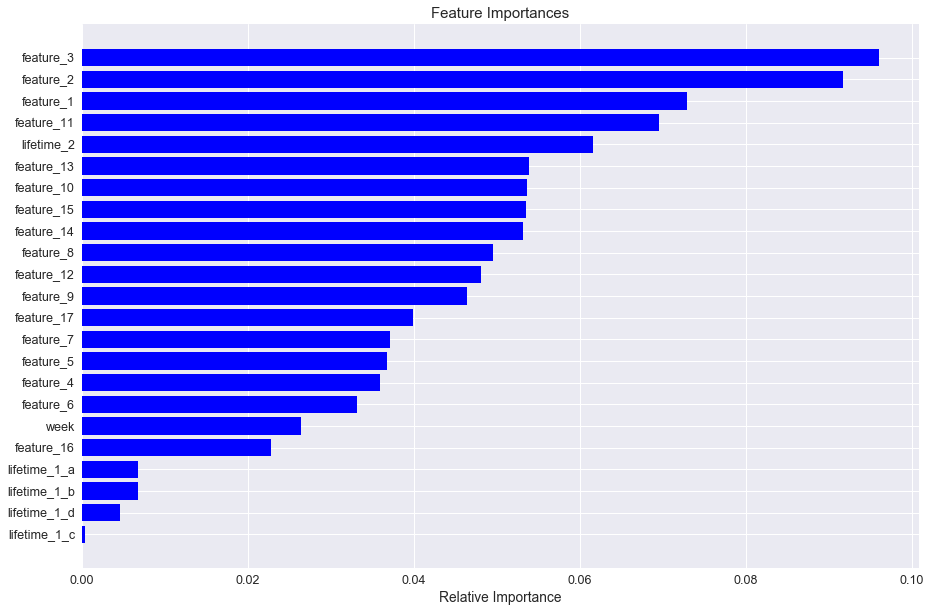

In [101]:
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

f, ax = plt.subplots(figsize=(15, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [139]:
df_feature_3 = pd.concat([df['flag'], pd.cut(df['feature_3'], 8)], axis=1)

In [141]:
funcs = {
    'flag': {
        'n1': 'sum',
        'tf': 'mean',
    }
}

In [149]:
df_feature_3.groupby('feature_3').pipe(agg_assign, fdict=funcs).reset_index()

feature_3 flag   
                       n1 tf
0    (0.817, 23.875]  338  1
1    (23.875, 46.75]  380  0
2    (46.75, 69.625]  217  0
3     (69.625, 92.5]   98  0
4    (92.5, 115.375]   20  0
5  (115.375, 138.25]    3  0
6  (138.25, 161.125]    0  0
7   (161.125, 184.0]    0  0

---

## Preprocessing

In [4]:
df.describe()

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_14,feature_15,feature_16,feature_17,lifetime_2,lifetime_1_a,lifetime_1_b,lifetime_1_c,lifetime_1_d,flag
count,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,...,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000
mean,368198.358347,3.292231,-2.893223,43.383140,54.476033,0.076942,0.923059,104.688290,0.065939,4070.988724,...,0.764485,70.344298,2.207273,13.469752,30.229091,0.614545,0.315041,0.001983,0.068430,0.349091
std,127993.952842,2.252106,16.372872,23.770959,30.592909,0.072091,0.072091,8.809467,0.065232,1298.174332,...,0.168306,18.660267,1.487941,12.423356,12.170176,0.486783,0.464609,0.044499,0.252524,0.476762
min,3767.000000,0.000000,-138.000000,1.000000,1.000000,0.000000,0.000000,92.857100,0.000000,1445.666700,...,0.000000,2.957809,1.000000,1.000000,-61.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,281494.000000,1.000000,-11.000000,26.000000,31.000000,0.026700,0.888900,100.000000,0.014700,2761.015900,...,0.722200,59.786836,1.000000,5.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,406948.000000,3.000000,-2.000000,40.000000,51.000000,0.062500,0.937500,100.750000,0.051700,4167.511100,...,0.802000,73.398889,2.000000,11.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,467864.000000,5.000000,6.000000,57.000000,74.000000,0.111100,0.973300,105.400000,0.098200,4941.105300,...,0.867600,83.759259,3.000000,17.000000,37.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,519341.000000,7.000000,77.000000,169.000000,184.000000,1.000000,1.000000,197.739100,0.666700,12593.900000,...,1.000000,180.861111,13.000000,195.000000,66.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 25 columns):
courier         3025 non-null int64
week            3025 non-null int64
feature_1       3025 non-null int64
feature_2       3025 non-null int64
feature_3       3025 non-null int64
feature_4       3025 non-null float64
feature_5       3025 non-null float64
feature_6       3025 non-null float64
feature_7       3025 non-null float64
feature_8       3025 non-null float64
feature_9       3025 non-null float64
feature_10      3025 non-null float64
feature_11      3025 non-null int64
feature_12      3025 non-null float64
feature_13      3025 non-null float64
feature_14      3025 non-null float64
feature_15      3025 non-null float64
feature_16      3025 non-null int64
feature_17      3025 non-null int64
lifetime_2      3025 non-null float64
lifetime_1_a    3025 non-null int64
lifetime_1_b    3025 non-null int64
lifetime_1_c    3025 non-null int64
lifetime_1_d    3025 non-null int64
flag 

No missings at this point.

<h6 class="text-muted">Standardization</h6>

Necessary since there are features with completely different scales.

In [6]:
from sklearn.preprocessing import StandardScaler

predictors = [x for x in df.columns if x not in ['flag', 'courier']]

scaler = StandardScaler()
df2 = pd.DataFrame(scaler.fit_transform(df[predictors]), columns=predictors)
df2['flag'] = df['flag']
df2['courier'] = df['courier']

<h6 class="text-muted">PCA to extract new features</h6>

Following the hint provided, new features (2) will be extracted from `feature_3` in combination with other ones. We will use PCA in an iterative way until we find the right combination of features such that the principal components have a large predictive power.

In [7]:
features = ['feature_3','lifetime_1','lifetime_2']

# Separating out the features
X = df2.loc[:, features].values

# Separating out the target
y = df2[['flag']]

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [9]:
finalDf = pd.concat([principalDf, y], axis = 1)

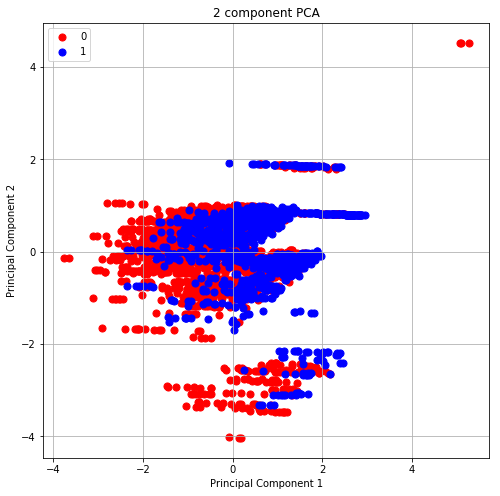

In [10]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 component PCA')
flags = [0,1]
colors = ['r','b']
for flag, color in zip(flags,colors):
    indicesToKeep = finalDf['flag'] == flag
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(flags)
ax.grid()

In [11]:
df3 = pd.concat([df2, finalDf[['PC1', 'PC2']]], axis=1)

In [12]:
predictors = [x for x in df3.columns if x not in ['flag', 'courier']]

In [13]:
# Choose all features except flag
features = [x for x in df3.columns if x not in ['flag']]
target = 'flag'

X = df3[features].values
y = df3[target].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [15]:
train = pd.DataFrame(X_train, columns=[features])
train[target] = list(y_train)

test = pd.DataFrame(X_test, columns=[features])
test[target] = y_test

Remove features not necessary for modelling:
* `courier`: not used to model since it is just an id (the model results would be definitely better but would not be realistic for production purposes).
* `feature_5`: we have seen that has complete negative correlation with `feature_4`.
* `lifetime_1`: already included in PCA features.

In [16]:
predictors.remove('feature_5')
predictors.remove('lifetime_1')

---
<h2>Model 1 <span class="text-muted">SVM</span></h2>

In [17]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0)
clf.fit(train[predictors].values, train['flag'].values.flatten())

#print(clf.coef_)
#print(clf.intercept_)

print( "\nModel Report (Train)")
print( "AUC Score: %f" % metrics.roc_auc_score(train['flag'].values, clf.predict(train[predictors].values)))

print( "\nModel Report (Test)")
print( "AUC Score: %f" % metrics.roc_auc_score(test['flag'].values, clf.predict(test[predictors].values)))


Model Report (Train)
AUC Score: 0.691871

Model Report (Test)
AUC Score: 0.674636


---
<h2>Model 2 <span class="text-muted">Lasso</span></h2>

In [18]:
from sklearn.linear_model import Lasso

clf = Lasso(alpha=0.001, random_state=0)
clf.fit(train[predictors].values, train['flag'].values)

print( "\nModel Report (Train)")
print( "AUC Score: %f" % metrics.roc_auc_score(train['flag'].values, clf.predict(train[predictors].values)))

print( "\nModel Report (Test)")
print( "AUC Score: %f" % metrics.roc_auc_score(test['flag'].values, clf.predict(test[predictors].values)))


Model Report (Train)
AUC Score: 0.789857

Model Report (Test)
AUC Score: 0.792427


---
<h2>Model 3 <span class="text-muted">XGBoost</span></h2>

In [19]:
import xgboost as xgb
from xgboost import XGBClassifier

def modelfit(alg, dtrain, dtest, predictors, verbose=0, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values.flatten())
        cvresult = xgb.cv(
            xgb_param, 
            xgtrain, 
            num_boost_round=alg.get_params()['n_estimators'], 
            nfold=cv_folds,
            metrics='auc', 
            early_stopping_rounds=early_stopping_rounds, 
            verbose_eval=verbose)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(alg.get_params())
    
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target].values.flatten(),eval_metric='auc')
        
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # Print model report:
    print( "\nModel Report (Train)")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print( "AUC Score: %f" % metrics.roc_auc_score(dtrain[target].values, dtrain_predprob))
    
    # Predict validation set:
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]

    # Print model report:
    print( "\nModel Report (Test)")
    print( "AUC Score: %f" % metrics.roc_auc_score(dtest[target].values, dtest_predprob))
    
    features_df = pd.DataFrame({'feature': pd.Series(predictors), 'importance': alg.feature_importances_})
    features_df = features_df.sort_values('importance', ascending=False)
    ind = np.arange(len(features_df['feature'].values))    # the x locations for the groups
    
    pyplot.figure(num=None, figsize=[12,4])
    pyplot.bar(range(len(features_df)), features_df['importance'].values)
    pyplot.xticks(ind, features_df['feature'].values, rotation='vertical')
    pyplot.ylabel('Feature Importance Score')
    pyplot.show()

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* __max_depth = 5:__ This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
* __min_child_weight = 1:__ A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
* __gamma = 0:__ A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
* __subsample, colsample_bytree = 0.8:__ This is a commonly used used start value. Typical values range between 0.5-0.9.
* __scale_pos_weight = 1:__ Because of high class imbalance.

Please note that all the above are just initial estimates and will be tuned later. Lets take a low __learning rate of 0.1__ here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 133, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9658
AUC Score: 0.994757

Model Report (Test)
AUC Score: 0.845097


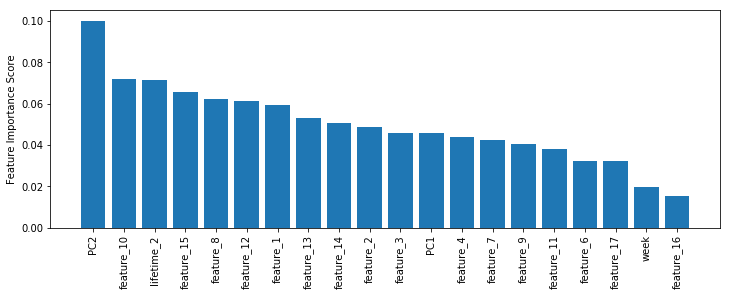

In [20]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, test, predictors)

## GridSearch

We use GridSearch to find the optimal combination of hyperparameters. A search consists of:
* an estimator (regressor or classifier such as sklearn.svm.SVC());
* a parameter space;
* a method for searching or sampling candidates;
* a cross-validation scheme; and
* a score function.

<h6 class="text-muted">Step 1: Tune max_depth and min_child_weight</h6>

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [21]:
from sklearn.model_selection import GridSearchCV #Perforing grid search

param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=False)

gsearch1.fit(train[predictors].values, train[target].values.flatten())

#gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.8289158879664533)

There is high risk of overfitting for such large value for `max_depth`. Therefore, we are going to explore a narrower parameter space which should yield better results when generalising to test dataset.

In [22]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[1,2,3]
}

gsearch2 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.1,
        n_estimators=300,
        max_depth=5,
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5, return_train_score=True)

gsearch2.fit(train[predictors].values,train[target].values.flatten())

#gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 2}, 0.8293294510883747)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 135, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.957
AUC Score: 0.992474

Model Report (Test)
AUC Score: 0.845291


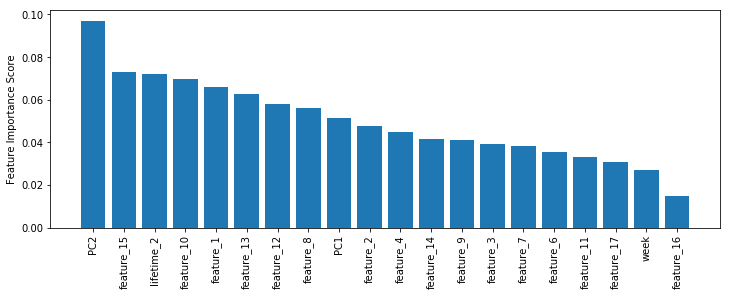

({'max_depth': 5, 'min_child_weight': 2}, 0.8293294510883747)

In [23]:
modelfit(gsearch2.best_estimator_, train, test, predictors)
gsearch2.best_params_, gsearch2.best_score_

The optimal values are `max_depth` = 5 and `min_child_weight` = 2, for now.

<h6 class="text-muted">Step 2: Tune gamma</h6>

Now let's tune gamma value using the parameters already tuned above. 

In [24]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch3.fit(train[predictors].values, train[target].values.flatten())

gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.8293294510883747)

This shows that our original value of `gamma` = 0 was optimal. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 135, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.957
AUC Score: 0.992474

Model Report (Test)
AUC Score: 0.845291


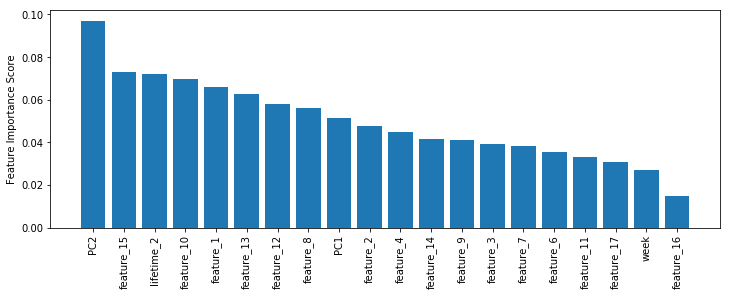

In [25]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2, train, test, predictors)

Here, we can see the improvement in score. So the final parameters are:

* `max_depth`: 5
* `min_child_weight`: 2
* `gamma`: 0

Nonetheless, if we manually raise the value of `gamma` to 0.1 the results improve both in the train and test set.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 155, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9669
AUC Score: 0.995703

Model Report (Test)
AUC Score: 0.856262


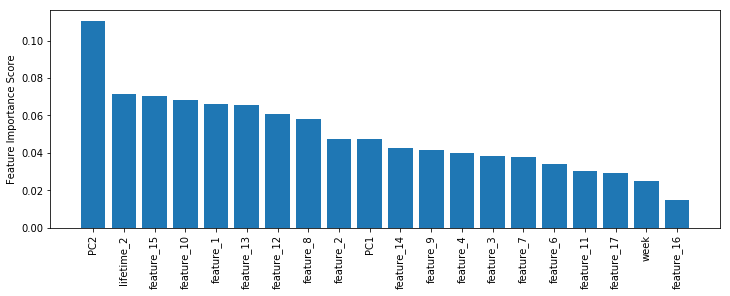

In [26]:
xgb2b = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2b, train, test, predictors)

<h6 class="text-muted">Step 3: Tune subsample and colsample_bytree</h6>

The next step would be try different `subsample` and `colsample_bytree` values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with. 

In [27]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch4.fit(train[predictors].values, train[target].values.flatten())

gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.8339379955193346)

Here, we found 0.8 as the optimum value for `colsample_bytree` and 0.9 for `subsample`. Now we should try values in 0.05 interval around these.

In [28]:
param_test5 = {
 'subsample':[i/100.0 for i in range(80,95,5)],
 'colsample_bytree':[i/100.0 for i in range(80,95,5)]
}

gsearch5 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch5.fit(train[predictors].values, train[target].values.flatten())

gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.85}, 0.8344829540442624)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.85, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 158, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.9}

Model Report (Train)
Accuracy : 0.968
AUC Score: 0.995684

Model Report (Test)
AUC Score: 0.853641


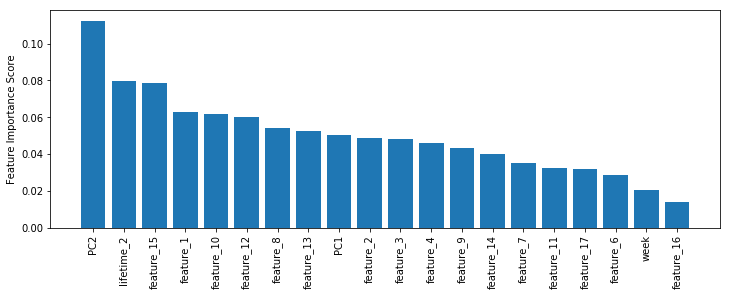

In [29]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb3, train, test, predictors)

The optimum values are:

* `subsample`: 0.90
* `colsample_bytree`: 0.85

However, 0.80 for both values works better.

<h6 class="text-muted">Step 4: Tuning Regularization Parameters</h6>

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as `gamma` provides a substantial way of controlling complexity. But we should always try it. I’ll tune `reg_alpha` value here and leave it upto you to try different values of `reg_lambda`.

In [30]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch6.fit(train[predictors].values, train[target].values.flatten())

gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([1.22983522, 1.05666127, 1.02097445, 1.05726171, 0.29442396]),
  'std_fit_time': array([0.0856927 , 0.02985603, 0.00999934, 0.02339077, 0.00567653]),
  'mean_score_time': array([0.01465616, 0.00977464, 0.01175094, 0.01066642, 0.00161309]),
  'std_score_time': array([1.25732882e-03, 1.99756380e-04, 2.29789242e-03, 5.56164910e-04,
         3.51333541e-05]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.80628272, 0.80879699, 0.8036945 , 0.8054397 , 0.7399651 ]),
  'split1_test_score': array([0.83565534, 0.83743012, 0.84886266, 0.83790339, 0.75944331]),
  'split2_test_score': array([0.8323572 , 0.82911823, 0.83040495, 0.8396338 , 0.75678114]),
  'split3_test_score': array([0.8413

You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 236, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9919
AUC Score: 0.999649

Model Report (Test)
AUC Score: 0.858544


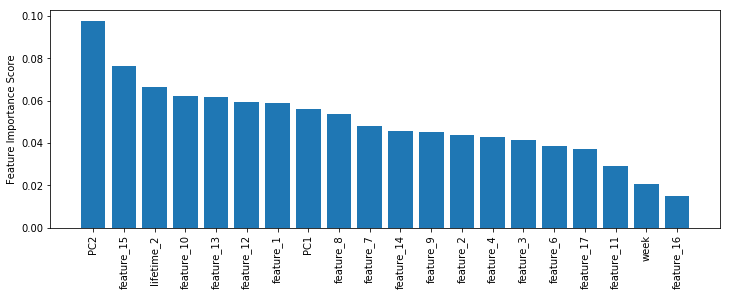

In [31]:
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb4, train, test, predictors)

<h6 class="text-muted">Step 5: Reducing the Learning Rate</h6>

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 1216, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 2, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9401
AUC Score: 0.986031

Model Report (Test)
AUC Score: 0.842184


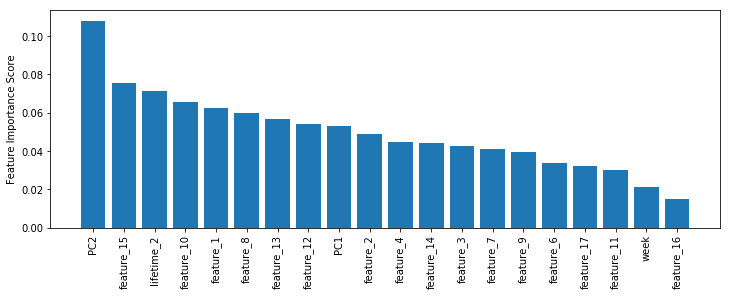

In [32]:
xgb5 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=2,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb5, train, test, predictors)

Reducing the `learning_rate` did no work as expected and the score reduced slightly.

<h6 class="text-muted">Saving the Model</h6>

In [33]:
import pickle

# save model to file
pickle.dump(xgb4, open("xgb.pickle.dat", "wb"))

<h6 class="text-muted">Exporting data</h6>

In [34]:
train['train'] = 1
test['train'] = 0

df_total = pd.concat([train, test]).reset_index().drop('index', axis=1)

/Users/moyandreu/coding/glovo/Data_Scientist_Interview/env/lib/python3.6/site-packages/pandas/core/generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [35]:
df_total.to_csv('./data/Courier_data_model.csv', sep=',', index=False)